# Classification demo of Amazon's Chronos Forecaster

This notebook is a short demo of how to switch Chronos from forecasting to classification. Since it is built upon Huggingface models, it is straightforward to switch the model head.

For simplicity, I will use [torchtime](https://github.com/philipdarke/torchtime) for loading univariate datasets. Next cell set up all the dataloaders and train/val/test split.


In [2]:
from torch.utils.data import DataLoader, TensorDataset
from torchtime.data import UEA
import torch

arrowhead = UEA(
    dataset="ArrowHead",
    split="train",
    train_prop=0.7,  # 70% training
    val_prop=0.2,  # 20% validation
    seed=123,
)
train_loader = DataLoader(arrowhead, batch_size=32, shuffle=True)

# Validation data
val_data = TensorDataset(
    arrowhead.X_val,
    arrowhead.y_val,
    arrowhead.length_val,
)

val_loader = DataLoader(val_data, batch_size=32)

# Test data
test_data = TensorDataset(
    arrowhead.X_test,
    arrowhead.y_test,
    arrowhead.length_test,
)

test_loader = DataLoader(test_data, batch_size=32)

Validating cache...


To fully understand how `torchtime` handles data, look at their Github page. Each `train` batch is a dict of `X`, `y` and `length`. The `X` is of shape `(batch_size, sequence_length, 2)`. The trailing 2 is due to that the first dimension is time stamps, and the second is the time series.


torch.Size([32, 251, 2])
torch.Size([32, 3])
torch.Size([32])


Text(0.5, 1.0, 'Class: 0')

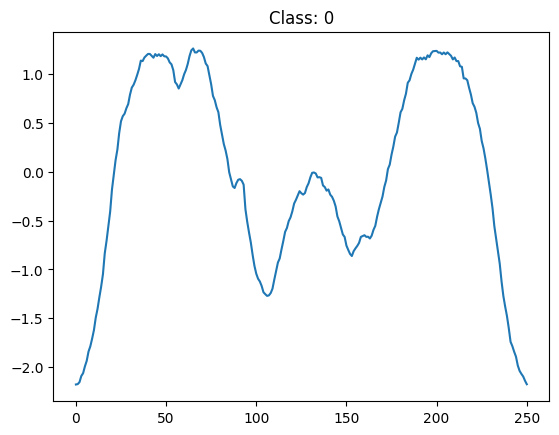

In [3]:
import matplotlib.pyplot as plt

# batch_size x max_seq_len x num_channels
# "By default, the first channel is a time stamp"
train_next_batch = next(iter(train_loader))
print(train_next_batch["X"].shape)  # torch.Size([32, 251, 2])
print(train_next_batch["y"].shape)  # torch.Size([32, 3])
print(train_next_batch["length"].shape)  # torch.Size([32])

# how to fetch the first time series in the batch
x = train_next_batch["X"][:, :, 1][0]
y = train_next_batch["y"][0].argmax()

plt.plot(x)
plt.title(f"Class: {y}")

Now, define some settings.


In [4]:
from torch.utils.data import Dataset, DataLoader
import torch
from torch.utils.data import DataLoader
from transformers import AdamW
import pandas as pd
import random
import numpy as np

batch_size = 32
device = "mps"
checkpoint = "amazon/chronos-t5-base"  # tiny, mini, small, base, large
lr = 3e-4

# What seeds are required to get reproducible results?
# How about setting them all.
random.seed(0)
torch.manual_seed(0)
np.random.seed(0)

Chronos is using a custom tokenizer. I am just loading that from their predefined model. This could probably be improved by fully understanding their tokenization.


In [5]:
from chronos import ChronosPipeline

pipeline = ChronosPipeline.from_pretrained(
    checkpoint,
    device_map=device,
    torch_dtype=torch.float16,
)

tokenizer = pipeline.tokenizer

Switching head with Huggingface is straightforward. I am using the `AutoModelForSequenceClassification` class.


In [7]:
from transformers import AutoModelForSequenceClassification

# the y's are one-hot encoded
num_labels = len(train_next_batch["y"][0])

model = AutoModelForSequenceClassification.from_pretrained(
    checkpoint, num_labels=num_labels
)

print(f"The number of labels are {num_labels}")

Some weights of T5ForSequenceClassification were not initialized from the model checkpoint at amazon/chronos-t5-base and are newly initialized: ['classification_head.dense.bias', 'classification_head.dense.weight', 'classification_head.out_proj.bias', 'classification_head.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


3


Next cells add some dropout to the newly attached head, as it's initally set to 0.0.


In [9]:
new_dropout_rate = 0.2
if hasattr(model, "classification_head") and hasattr(
    model.classification_head, "dropout"
):
    model.classification_head.dropout.p = new_dropout_rate
else:
    print(
        "The model does not have a classification_head with a dropout attribute in the expected location."
    )

model

T5ForSequenceClassification(
  (transformer): T5Model(
    (shared): Embedding(4096, 768)
    (encoder): T5Stack(
      (embed_tokens): Embedding(4096, 768)
      (block): ModuleList(
        (0): T5Block(
          (layer): ModuleList(
            (0): T5LayerSelfAttention(
              (SelfAttention): T5Attention(
                (q): Linear(in_features=768, out_features=768, bias=False)
                (k): Linear(in_features=768, out_features=768, bias=False)
                (v): Linear(in_features=768, out_features=768, bias=False)
                (o): Linear(in_features=768, out_features=768, bias=False)
                (relative_attention_bias): Embedding(32, 12)
              )
              (layer_norm): T5LayerNorm()
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (1): T5LayerFF(
              (DenseReluDense): T5DenseActDense(
                (wi): Linear(in_features=768, out_features=3072, bias=False)
                (wo): Linear(in_featur

Print to get the status of which parameters to train. By default, all layers are thawed.


In [ ]:
# NOTE: uncomment to freeze all layers but the classification head
# for name, param in model.named_parameters():
#     if not name.startswith("classification_head"):  # choose whatever you like here
#         param.requires_grad = False

# print the status of the parameters
for name, param in model.named_parameters():
    status = "🥶" if not param.requires_grad else "🔥"
    print(f"{status} {name}: Requires grad is set to '{param.requires_grad}'")

Setup the optimizer and num epochs.


In [ ]:
optimizer = AdamW(model.parameters(), lr=lr)
num_epochs = 10
num_training_steps = num_epochs * len(train_loader)

Helper function to evaluate the model.


In [ ]:
import evaluate


def evaluate_model(model, dataloader, device="mps", testing=False, testing_batches=0):
    total_loss = 0.0
    metric = evaluate.load("accuracy")
    model.eval()
    for i, batch in enumerate(dataloader):
        # select the time series data:
        X = batch[0][:, :, 1]
        y = batch[1].argmax(dim=1)

        # TOKENIZE and move to device
        token_ids, attention_mask, scale = tokenizer.input_transform(X)
        # NOTE: setting occupants to torch.int64, the HF API understand it's a label
        y = y.to(device).to(torch.int64)  # Ensure correct dtype and move to device
        token_ids = token_ids.to(device)
        attention_mask = attention_mask.to(device)

        # NOTE: ValueError: Expected input batch_size (32) to match target batch_size (64).
        # turn occupants into an int tensor
        # occupants_one_hot = torch.nn.functional.one_hot(
        #     occupants.to(torch.int64), num_classes=2
        # )
        with torch.no_grad():
            outputs = model(
                input_ids=token_ids, attention_mask=attention_mask, labels=y
            )

        logits = outputs.logits
        total_loss += outputs.loss.item()
        predictions = torch.argmax(logits, dim=-1)
        # print(predictions)
        metric.add_batch(predictions=predictions, references=y)
        if testing and i == testing_batches - 1:
            break
    avg_loss = total_loss / len(dataloader)
    return avg_loss, metric.compute()["accuracy"]

In [ ]:
# Display realtime logging :o super-cell-magic
from tqdm.auto import tqdm

progress_bar = tqdm(range(num_training_steps))
device = "mps"  # Yes, I am using an MacBook M1 🙋🏻‍♂️
model.to(device)
model.train()

for epoch in range(num_epochs):
    losses = []
    for i, batch in enumerate(train_loader):
        # select the time series data:
        X = batch["X"][:, :, 1]
        y = batch["y"].argmax(dim=1)

        # TOKENIZE and move to device
        token_ids, attention_mask, scale = tokenizer.input_transform(X)
        # NOTE: setting y to torch.int64, so the HF API understand it's a label
        y = y.to(device).to(torch.int64)  # Ensure correct dtype and move to device
        token_ids = token_ids.to(device)
        attention_mask = attention_mask.to(device)

        # NOTE: ValueError: Expected input batch_size (32) to match target batch_size (64).
        # turn occupants into an int tensor
        # occupants_one_hot = torch.nn.functional.one_hot(
        #     occupants.to(torch.int64), num_classes=2
        # )
        outputs = model(input_ids=token_ids, attention_mask=attention_mask, labels=y)
        loss = outputs.loss
        loss.backward()
        losses.append(loss.item())

        # Update moving average and print
        avg_loss_chat_gupete = moving_average.update(loss.item())
        progress_bar.set_description(
            f"Epoch: {epoch} | Batch: {i} | Moving Avg Loss: {avg_loss_chat_gupete:.4f}"
        )

        print(f"Epoch: {epoch} | Batch: {i} | Loss: {avg_loss_chat_gupete:.4f}")

        optimizer.step()
        # lr_scheduler.step()
        optimizer.zero_grad()
        progress_bar.update(1)
    train_loss = sum(losses) / len(losses)
    val_loss, val_accuracy = evaluate_model(model, val_loader, device)
    # log to wandb
    wandb.log(
        {
            "train": {"loss": train_loss},
            "validation": {"loss": val_loss, "accuracy": val_accuracy},
        }
    )
    print(
        f"Epoch {epoch} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | Val Acc: {val_accuracy:.4f}"
    )